In [1]:
%%capture
import logging
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["numexpr", "numba", "bokeh", "matplotlib", "tornado", "Comm"],
)

In [5]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from bokeh.io import output_notebook

from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.utils import to_describe
from src.visualization.plot_stimulus import plot_stimulus_with_shapes

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
def load_configuration(file_path: str) -> dict:
    """Load configuration from a TOML file."""
    file_path = Path(file_path)
    with open(file_path, "rb") as file:
        return tomllib.load(file)


config = load_configuration("src/experiments/measurement/measurement_config.toml")[
    "stimulus"
]

In [4]:
config = {
    "seeds": config["seeds"],
    "sample_rate": config["sample_rate"],
    "half_cycle_num": config["half_cycle_num"],
    "period_range": config["period_range"],
    "amplitude_range": config["amplitude_range"],
    "inflection_point_range": config["inflection_point_range"],
    "shorten_expected_duration": config["shorten_expected_duration"],
    "major_decreasing_half_cycle_num": config["major_decreasing_half_cycle_num"],
    "major_decreasing_half_cycle_period": config["major_decreasing_half_cycle_period"],
    "major_decreasing_half_cycle_amplitude": config[
        "major_decreasing_half_cycle_amplitude"
    ],
    "major_decreasing_half_cycle_min_y_intercept": config[
        "major_decreasing_half_cycle_min_y_intercept"
    ],
    "plateau_num": config["plateau_num"],
    "plateau_duration": config["plateau_duration"],
    "plateau_percentile_range": config["plateau_percentile_range"],
    "prolonged_minima_num": config["prolonged_minima_num"],
    "prolonged_minima_duration": config["prolonged_minima_duration"],
}
assert len(config["seeds"]) == len(set(config["seeds"])), "Seeds must be unique"
assert len(config["seeds"]) == 12, "There must be 12 seeds"

dummy_participant = {
    "temperature_baseline": 47.0,
    "temperature_range": 1.5,  # VAS 0 - VAS 70
}


dummy_config = {
    "seeds": [1, 2, 3],
    "half_cycle_num": 2,
    "period_range": [2, 2],
    "major_decreasing_half_cycle_num": 0,
    "shorten_expected_duration": 0,
    "amplitude_range": [0.9, 1.0],
    "plateau_num": 0,
    "prolonged_minima_num": 0,
}

# Plot one random seed
config.update(dummy_participant)
seed = np.random.randint(0, 1000)
stimulus = StimulusGenerator(config, debug=0, seed=396)

# print("Plot one random seed:")
plot_stimulus_with_shapes(stimulus)

## Show all stimuli

We want 12 seeds for unpredictable stimuli (note peak-and-end-rule)
- some with plateau in last peak
- some with low end temperature
- no mere sinosiodal patterns

In [5]:
from pprint import pprint

stimuli = pl.DataFrame()
interval_dict = dict()
for seed in config["seeds"]:
    stimulus = StimulusGenerator(config, seed)
    df = pl.DataFrame(
        {
            "y": stimulus.y,
            "time": np.arange(len(stimulus.y)),
            "seed": np.array([seed] * len(stimulus.y)),
        }
    )
    interval_dict[seed] = stimulus.major_decreasing_intervals_ms
    stimuli = pl.concat([stimuli, df])

pprint(interval_dict)
output_notebook()  # annoyingly, this needs to be called again or the plot will not show
stimuli.plot(
    x="time",
    y="y",
    kind="line",
    groupby="seed",
    ylim=config["temperature_baseline"]
    + np.array([-1, 1]) * config["temperature_range"] / 2,
)

{133: [(10000, 30000), (65000, 85000), (147000, 167000)],
 243: [(47000, 67000), (99000, 119000), (131000, 151000)],
 265: [(44000, 64000), (92000, 112000), (147000, 167000)],
 396: [(69000, 89000), (99000, 119000), (141000, 161000)],
 467: [(28000, 48000), (90000, 110000), (160000, 180000)],
 658: [(13000, 33000), (58000, 78000), (135000, 155000)],
 681: [(44000, 64000), (93000, 113000), (160000, 180000)],
 743: [(12000, 32000), (71000, 91000), (160000, 180000)],
 806: [(40000, 60000), (106000, 126000), (160000, 180000)],
 841: [(35000, 55000), (92000, 112000), (160000, 180000)],
 870: [(18000, 38000), (62000, 82000), (119000, 139000)],
 952: [(9000, 29000), (54000, 74000), (160000, 180000)]}


Loading BokehJS ...

BokehModel(combine_events=True, render_bundle={'docs_json': {'ddfb4299-de5f-4327-bcb3-b3975e8be18c': {'version…

In [6]:
out = stimuli.group_by("seed", maintain_order=True).agg(to_describe("y"))
out

seed,y_count,y_null_count,y_mean,y_std,y_min,y_25%,y_50%,y_75%,y_max
i64,u32,u32,f64,f64,f64,f64,f64,f64,f64
133,1800,0,46.923677,0.421417,46.25,46.665601,46.77629,47.232711,47.746504
243,1800,0,46.936088,0.417877,46.25,46.628212,46.89741,47.273344,47.738635
265,1800,0,46.933886,0.440374,46.25,46.596208,46.779867,47.291213,47.744373
396,1800,0,46.970278,0.413692,46.25,46.728107,46.936483,47.308829,47.731835
467,1800,0,46.967071,0.419495,46.25,46.685108,46.972487,47.291938,47.737302
658,1800,0,46.96046,0.41285,46.25,46.621278,46.966524,47.264738,47.704574
681,1800,0,46.932364,0.407685,46.25,46.647874,46.942859,47.242448,47.739538
743,1800,0,46.963318,0.410683,46.25,46.715073,46.884511,47.289045,47.738548
806,1800,0,46.901926,0.438545,46.25,46.566414,46.72672,47.242545,47.749272


In [7]:
output_notebook()
stimuli.plot(x="time", y="y", kind="line", groupby="seed", ylim=[46, 48])

Loading BokehJS ...

BokehModel(combine_events=True, render_bundle={'docs_json': {'606b3784-be8f-4483-826e-d2c5a6f2052a': {'version…

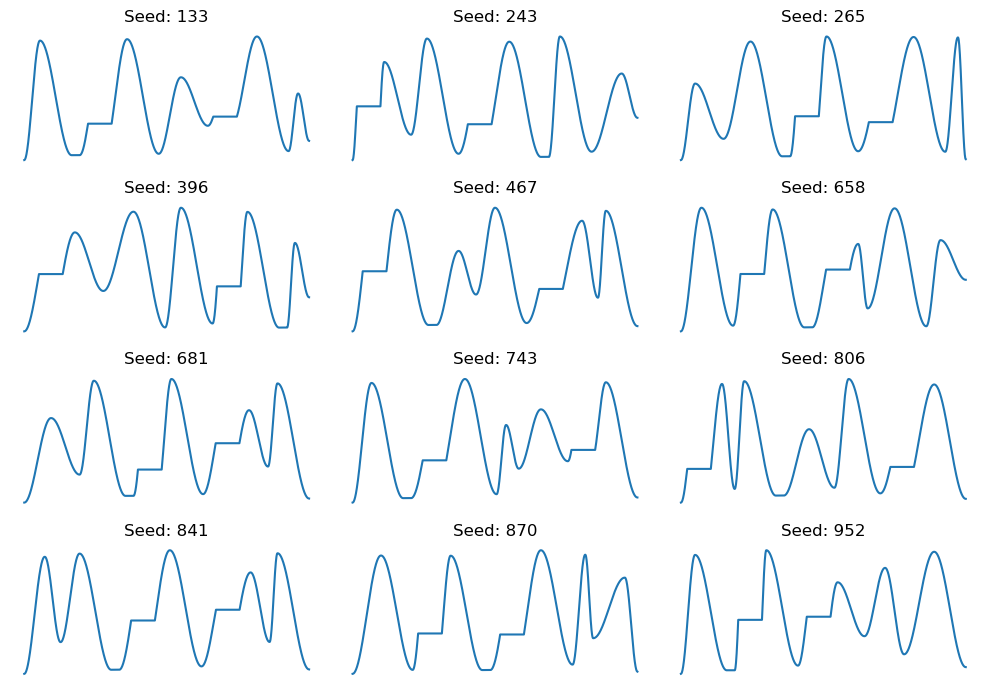

In [8]:
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
axes = axes.flatten()

grouped = stimuli.group_by("seed", maintain_order=True).agg(pl.col("time"), pl.col("y"))
for i, row in enumerate(grouped.to_dicts()):
    ax = axes[i]
    ax.plot(row["time"], row["y"])
    ax.set_title(f"Seed: {row['seed']}")
    ax.axis(False)


plt.tight_layout()
plt.show()